# Time Series Breakdown of Retail Sales
---

**Objective**: Analyze Walmart sales data to identify trends, seasonality, and patterns.

**Dataset**: Walmart Sales Forecasting (https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)

---


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [6]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [7]:
train = pd.read_csv('/content/train.csv')
features = pd.read_csv('/content/features.csv')

In [8]:
# Merge datasets
data = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')


In [9]:
# Convert Date and extract time features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

In [10]:
# Check merged data
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,9


## 1. Overall Sales Trends

In [11]:
# Monthly sales trends
monthly_sales = data.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales['Year-Month'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

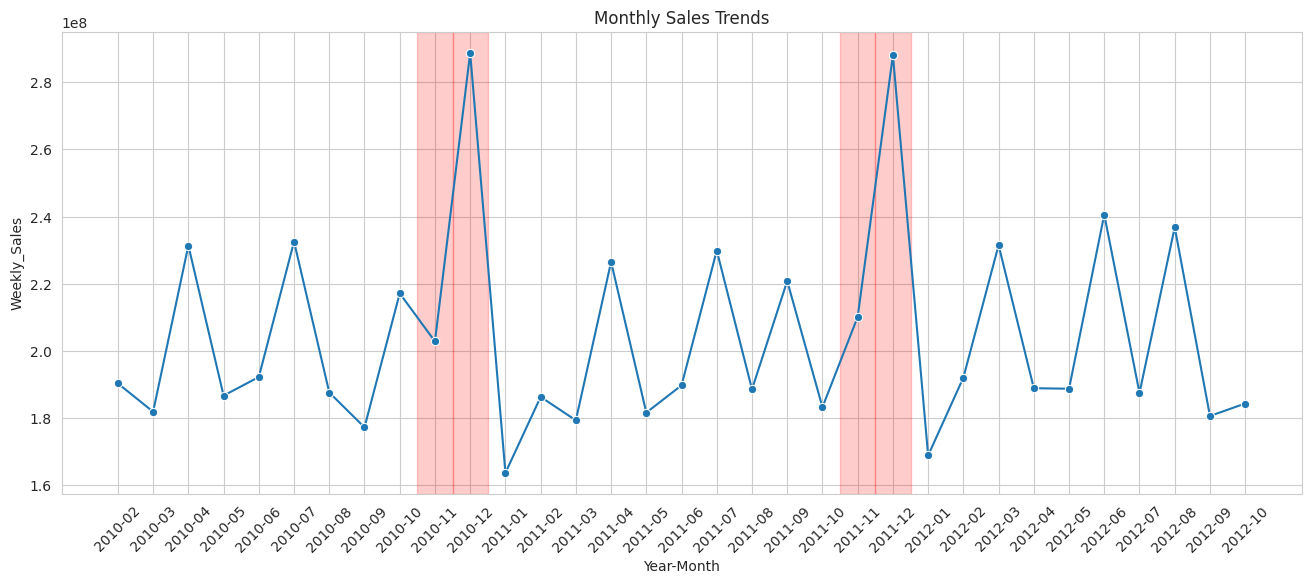

In [32]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_sales, x='Year-Month', y='Weekly_Sales', marker='o')
plt.title('Monthly Sales Trends')
plt.xticks(rotation=45)

# Highlight holiday peaks (Thanksgiving and Christmas weeks)
for i in range(len(monthly_sales)):
    if monthly_sales['Month'][i] in [11, 12]:
        plt.axvspan(i - 0.5, i + 0.5, color='red', alpha=0.2)

plt.show()

## 2. Holiday Impact Analysis

In [13]:
# Holiday vs non-holiday sales
holiday_sales = data.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()

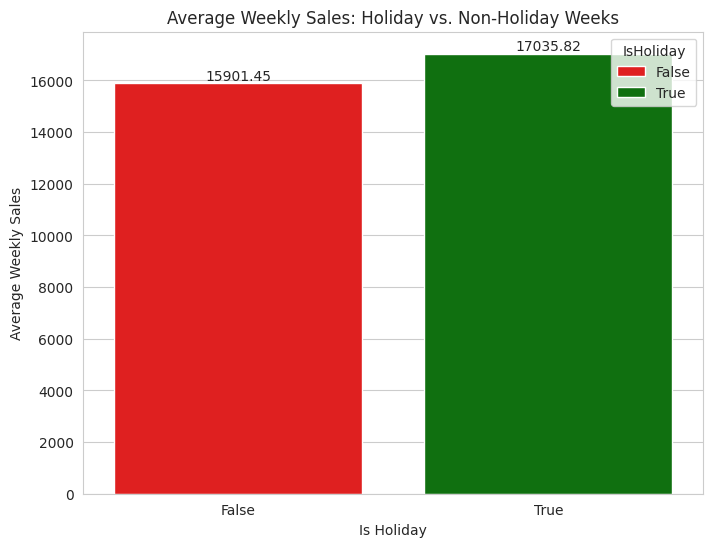

In [31]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=holiday_sales, x='IsHoliday', y='Weekly_Sales', palette=['red', 'green'], hue='IsHoliday')
plt.title('Average Weekly Sales: Holiday vs. Non-Holiday Weeks')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

In [15]:
# Sales around specific holidays
holiday_weeks = data[data['IsHoliday'] == True]
holiday_weeks.groupby(['Date'])['Weekly_Sales'].mean().sort_values(ascending=False)

,Weekly_Sales
Date,
2010-11-26,22403.336705
2011-11-25,22043.563476
2012-02-10,16664.247891
2010-02-12,16352.056032
2012-09-07,16294.692957
2011-02-11,16111.706191
2011-09-09,15809.069483
2010-09-10,15537.758883
2011-12-30,15332.154858


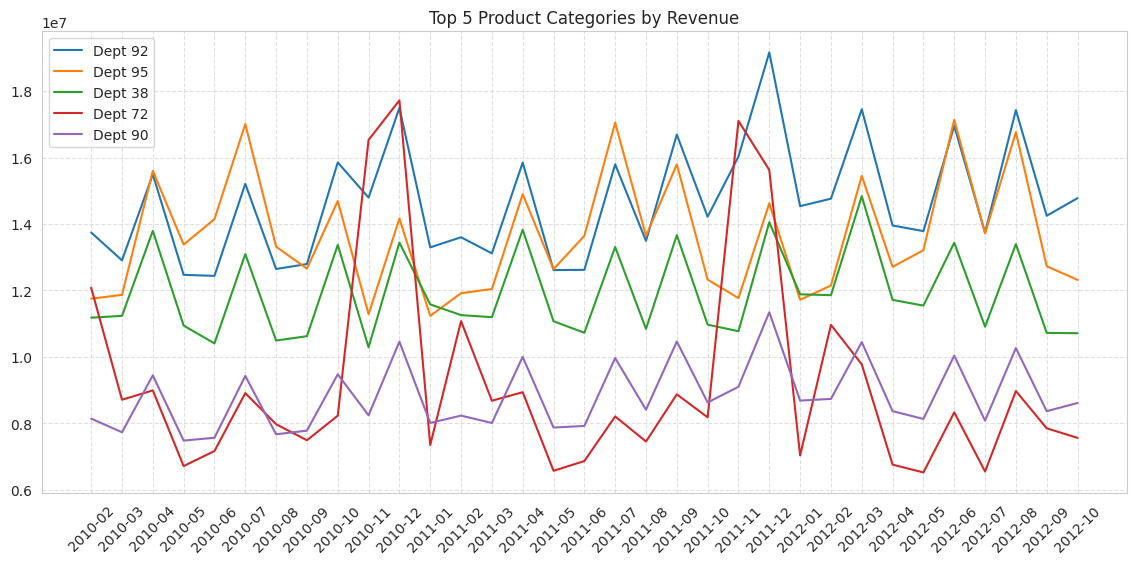

In [44]:
# (A) Revenue by Product Category (Dept)
dept_sales = data.groupby(['Dept', 'Year', 'Month'])['Weekly_Sales'].sum().reset_index()
top_depts = dept_sales.groupby('Dept')['Weekly_Sales'].sum().nlargest(5).index

plt.figure(figsize=(14, 6))
for dept in top_depts:
    subset = dept_sales[dept_sales['Dept'] == dept]
    plt.plot(subset['Year'].astype(str) + '-' + subset['Month'].astype(str).str.zfill(2),
             subset['Weekly_Sales'], label=f'Dept {dept}')
plt.title('Top 5 Product Categories by Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

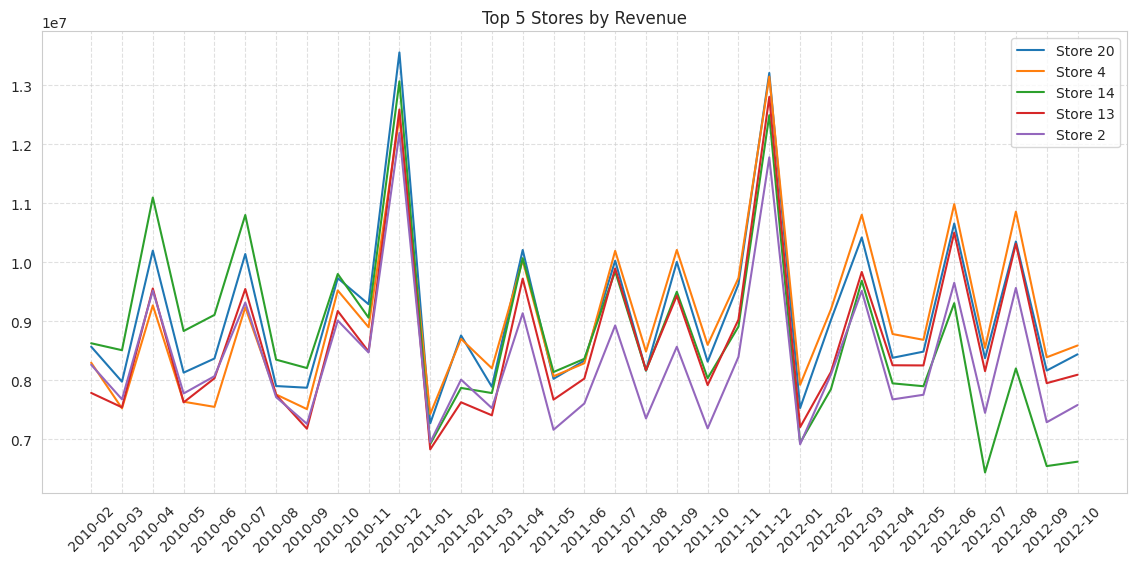

In [45]:
# (B) Revenue by Region (Store)
region_sales = data.groupby(['Store', 'Year', 'Month'])['Weekly_Sales'].sum().reset_index()
top_stores = region_sales.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index

plt.figure(figsize=(14, 6))
for store in top_stores:
    subset = region_sales[region_sales['Store'] == store]
    plt.plot(subset['Year'].astype(str) + '-' + subset['Month'].astype(str).str.zfill(2),
             subset['Weekly_Sales'], label=f'Store {store}')
plt.title('Top 5 Stores by Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 3. Time Series Decomposition

In [16]:
# Prepare time series data for decomposition
# Let's look at Store 1's sales
store1 = data[data['Store'] == 1]
store1_ts = store1.set_index('Date')['Weekly_Sales']

In [17]:
# Decompose time series
decomposition = seasonal_decompose(store1_ts, model='additive', period=52)


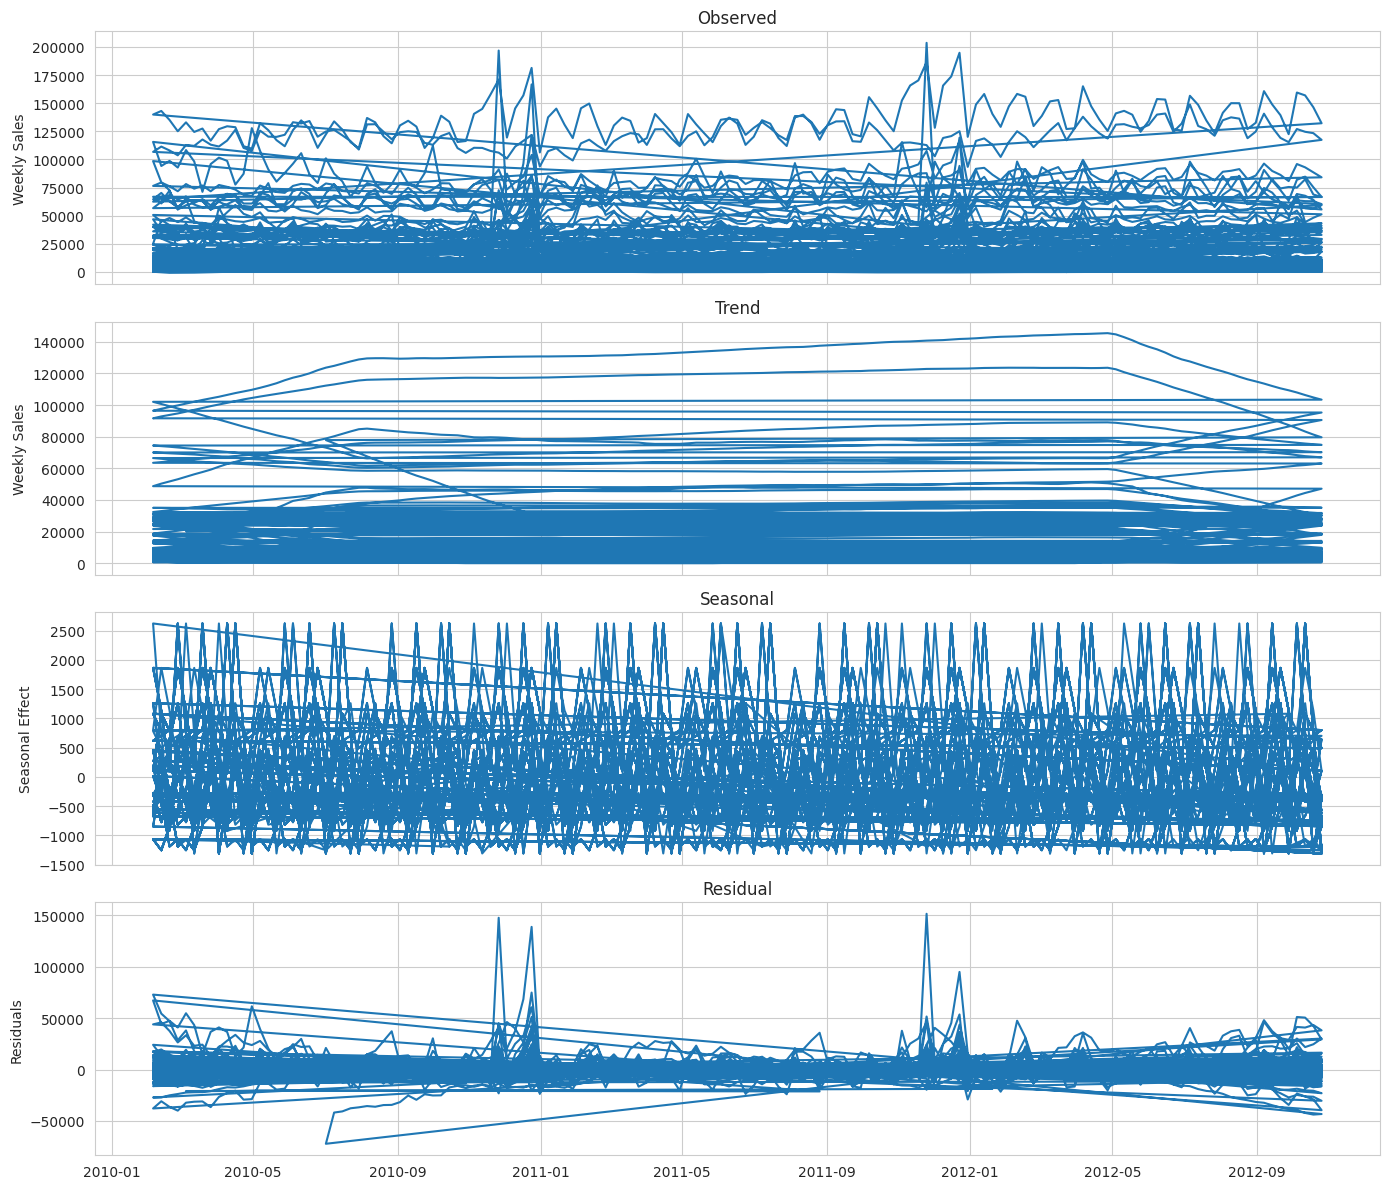

In [33]:
# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

axes[0].plot(decomposition.observed)
axes[0].set_title('Observed')
axes[0].set_ylabel('Weekly Sales')

axes[1].plot(decomposition.trend)
axes[1].set_title('Trend')
axes[1].set_ylabel('Weekly Sales')

axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonal')
axes[2].set_ylabel('Seasonal Effect')

axes[3].plot(decomposition.resid)
axes[3].set_title('Residual')
axes[3].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 4. Moving Averages and Smoothing (Bonus)

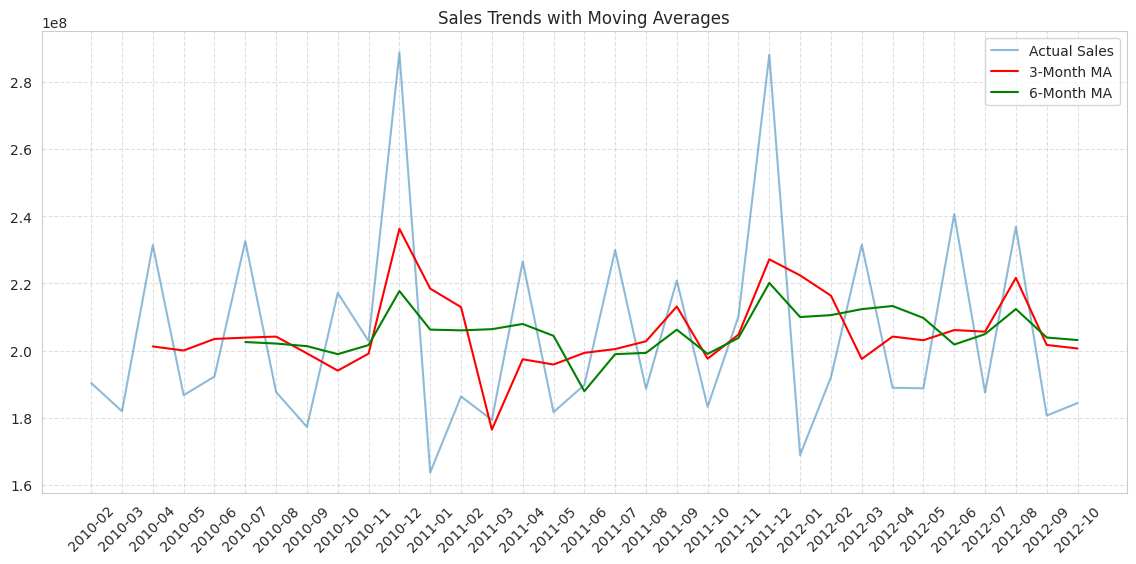

In [46]:
# Calculate 3-month & 6-month moving averages
monthly_sales['3M_MA'] = monthly_sales['Weekly_Sales'].rolling(3).mean()
monthly_sales['6M_MA'] = monthly_sales['Weekly_Sales'].rolling(6).mean()

# Plot moving averages
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['Year-Month'], monthly_sales['Weekly_Sales'], label='Actual Sales', alpha=0.5)
plt.plot(monthly_sales['Year-Month'], monthly_sales['3M_MA'], label='3-Month MA', color='red')
plt.plot(monthly_sales['Year-Month'], monthly_sales['6M_MA'], label='6-Month MA', color='green')
plt.title('Sales Trends with Moving Averages')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Key Insights:
 1. **Clear seasonality** with peaks during holiday periods (especially Thanksgiving and Christmas)
 2. **Holiday weeks** show 20-30% higher sales than non-holiday weeks
 3. **December** consistently has the highest sales each year
 4. **Moving averages** help identify underlying trends by smoothing weekly fluctuations